# Understanding feature importance with SHAP based on StackingClassifier model

In this notebook, the composite model developed based on the StackingClassifier is used to calculate feature importance with the SHAP module.

First, we load required modules and data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [3]:
data = pd.read_csv("../02_data_preparation/yoghurt_w_dummy_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21251 entries, 0 to 21250
Data columns (total 67 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 21251 non-null  int64  
 1   first_purchase             21251 non-null  bool   
 2   shelf_price                21251 non-null  float64
 3   pct_disc                   21251 non-null  float64
 4   pct_retail_disc            21251 non-null  float64
 5   pct_coupon_disc            21251 non-null  float64
 6   display_1                  21251 non-null  int64  
 7   display_2                  21251 non-null  int64  
 8   display_3                  21251 non-null  int64  
 9   display_4                  21251 non-null  int64  
 10  display_5                  21251 non-null  int64  
 11  display_6                  21251 non-null  int64  
 12  display_7                  21251 non-null  int64  
 13  display_9                  21251 non-null  int

In [4]:
data.drop(labels=["Unnamed: 0", "display_1", "display_5", "display_A", "campaign_6.0", "campaign_30.0", "description_TypeC"],
          axis = 1, inplace = True)

In [5]:
pd.set_option("display.max_columns", None)
data.describe(include = "all")

,first_purchase,shelf_price,pct_disc,pct_retail_disc,pct_coupon_disc,display_2,display_3,display_4,display_6,display_7,display_9,mailer_A,mailer_C,mailer_D,mailer_H,mailer_J,marital_status_A,marital_status_B,homeowner_Homeowner,homeowner_Probable Owner,homeowner_Probable Renter,homeowner_Renter,hhcomp_1 Adult Kids,hhcomp_2 Adults Kids,hhcomp_2 Adults No Kids,hhcomp_Single Female,hhcomp_Single Male,kid_category_1,kid_category_2,kid_category_3+,kid_category_None/Unknown,age_19-24,age_25-34,age_35-44,age_45-54,age_55-64,age_65+,income_100-124K,income_125-149K,income_15-24K,income_150-174K,income_175-199K,income_200-249K,income_25-34K,income_250K+,income_35-49K,income_50-74K,income_75-99K,income_Under 15K,hhsize_1,hhsize_2,hhsize_3,hhsize_4,hhsize_5+,campaign_8.0,campaign_13.0,campaign_18.0,campaign_29.0,description_TypeA,description_TypeB
count,21251,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.00000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,14083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.156933,0.158316,0.153330,0.004987,0.011152,0.007623,0.001082,0.005459,0.012046,0.004047,0.148699,0.001223,0.048751,0.008235,0.005270,0.488918,0.125406,0.686321,0.015152,0.005176,0.037834,0.061974,0.295092,0.314009,0.147711,0.122677,0.159240,0.098537,0.102254,0.63997,0.042727,0.211896,0.276975,0.347701,0.067009,0.053692,0.080420,0.074820,0.054586,0.085972,0.017646,0.006870,0.079384,0.017646,0.180086,0.224037,0.126394,0.052139,0.280975,0.374476,0.156746,0.089596,0.098207,0.076373,0.077879,0.075855,0.006776,0.230248,0.006776
std,NaN,1.104681,0.145841,0.137543,0.044610,0.105017,0.086979,0.032881,0.073682,0.109096,0.063488,0.355800,0.034958,0.215351,0.090374,0.072407,0.499889,0.331186,0.463999,0.122161,0.071761,0.190798,0.241113,0.456095,0.464131,0.354821,0.328073,0.365908,0.298046,0.302989,0.48002,0.202247,0.408661,0.447515,0.476252,0.250043,0.225413,0.271948,0.263107,0.227175,0.280330,0.131665,0.082604,0.270344,0.131665,0.384268,0.416956,0.332301,0.222312,0.449486,0.483999,0.363569,0.285609,0.297602,0.265600,0.267987,0.264773,0.082040,0.421001,0.082040
min,NaN,0.350000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.400000,0.

In [6]:
X = data.drop("first_purchase", axis = 1)
y = data["first_purchase"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, stratify = y)

# Then we set up our stacking classifier as developed in the related notebook

In [10]:
estimators = [
    ("rf_3", RandomForestClassifier(n_jobs = -1, class_weight = "balanced",
                             max_depth = 20, max_samples = 0.7, min_samples_split = 6, n_estimators = 250, random_state = 42)),
    ("xgb_2", xgb.XGBClassifier(scale_pos_weight = 1.965, colsample_bytree = 0.6, colsample_bynode = 0.8, colsample_bylevel = 0.5, 
                                max_delta_step = 1, tree_method = "hist", objective = "binary:logistic",
                         alpha = 1, reg_lambda = 2, learning_rate = 0.2, max_depth = 14, min_child_weight = 3,
                         n_estimators = 300, subsample = 0.8, random_state = 42)),
    ("lgbm_unbalanced", lgb.LGBMClassifier(objective = "binary", max_depth = 9, 
                                      boosting_type = 'gbdt', colsample_bytree = 0.8, learning_rate= 0.5,  max_bin= 40, 
                                      min_child_samples= 50,  n_estimators= 400, num_leaves= 70,  reg_alpha= 0, random_state =42))]

In [11]:
stack_21 = StackingClassifier(estimators = estimators, n_jobs = -1, cv=5, 
                             final_estimator= lgb.LGBMClassifier(scale_pos_weight = 1.965, boosting_type = "goss", learning_rate = 0.1,
                                                                max_bin = 45, max_depth = 5, min_child_samples = 10,
                                                                n_estimators = 100, reg_alpha = 5), 
                             passthrough = True, stack_method = "predict")

In [12]:
stack_21.fit(X_train.values, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf_3',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=20,
                                                       max_samples=0.7,
                                                       min_samples_split=6,
                                                       n_estimators=250,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('xgb_2',
                                XGBClassifier(alpha=1, base_score=None,
                                              booster=None, callbacks=None,
                                              colsample_bylevel=0.5,
                                              colsample_bynode=0.8,
                                              colsample_bytree=0.6,
                               

## Calculate SHAP values

In [8]:
import shap

In [9]:
shap.initjs()

In [23]:
explainer_2 = shap.KernelExplainer(stack_21.predict, X_test[:1000])

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [24]:
shap_values_2 = explainer_2.shap_values(X_test[:1000])

  0%|          | 0/1000 [00:00<?, ?it/s]

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it wi

In [27]:
shap_2_df = pd.DataFrame(shap_values_2)

In [28]:
#For safey, we store the calculated shap values in a separate csv file
shap_2_df.to_csv("shap_2.csv")

In [10]:
shap_values = pd.read_csv("shap_2.csv")

In [11]:
shap_values.drop(labels = "Unnamed: 0", axis = 1, inplace = True)

In [12]:
shap_values

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
0,-0.014046,0.003689,0.091774,0.002275,-0.007813,-0.009495,0.0,-0.007093,0.000000,0.006791,0.018412,0.016256,0.000000,-0.005751,0.008845,0.013989,0.009101,-0.025338,0.000000,-0.011276,-0.007530,0.000000,0.043966,0.018401,-0.004314,0.017422,-0.002408,0.007483,0.007531,0.002394,-0.003333,0.024882,0.019944,0.121486,0.341817,0.005993,0.040776,-0.037019,0.002440,0.003954,0.001867,0.010133,-0.005566,-0.005119,-0.007273,0.000000,0.008397,0.003014,0.000000,0.019905,-0.016547,0.007400,0.004010,0.009308,0.006314,-0.047990,0.000000,-0.076812,-0.006247
1,-0.031230,-0.017986,-0.039899,0.000000,0.000000,0.027983,0.0,0.033741,0.000000,0.030897,0.033217,-0.002717,0.019901,0.000000,0.000000,-0.060551,0.033888,-0.028574,0.000000,0.010539,0.010777,-0.025314,-0.139514,-0.016366,0.000000,-0.023002,0.012841,-0.026331,-0.033341,-0.028913,0.000000,-0.009419,-0.102253,-0.048307,0.000000,-0.004960,0.000000,0.022965,0.007743,0.000000,-0.034243,0.011584,-0.012492,-0.011060,0.185889,0.036717,-0.032181,-0.021598,-0.021498,0.000000,-0.009165,0.000000,-0.095275,0.011921,-0.011624,-0.013654,-0.007291,0.050412,-0.033261
2,-0.060228,-0.027413,0.174367,-0.003504,-0.003444,-0.004091,0.0,0.006222,0.003881,0.000000,0.022048,0.004573,0.020088,0.000000,0.008246,0.110465,0.034053,-0.058173,-0.006292,0.013776,0.012461,0.003073,0.045794,-0.014408,0.002709,-0.003961,0.011408,-0.003910,0.007944,-0.018642,-0.010278,0.001461,0.023631,0.022128,-0.010195,0.001717,0.026173,0.034788,0.000000,0.028849,0.000000,0.000000,-0.012749,0.006593,-0.011730,0.116004,-0.008909,0.023772,0.048066,0.009254,-0.004995,-0.005524,0.000000,0.009752,0.008968,0.012015,0.008679,0.022169,-0.017682
3,0.505691,-0.014590,0.065588,0.000000,-0.004059,0.000000,0.0,0.000000,0.000000,0.000000,0.025579,0.000000,0.007454,0.003447,0.000000,0.000000,0.011792,-0.014095,0.000000,-0.005277,0.000000,0.000000,0.011556,0.002735,0.000000,0.006514,-0.005360,0.010100,-0.010238,0.006634,-0.008239,0.021302,-0.017349,0.012738,-0.003825,-0.008602,0.018229,0.002878,-0.002802,0.005575,0.000000,0.000000,0.000000,0.000000,0.008462,0.004147,0.000000,-0.003375,-0.007462,0.000000,0.002780,-0.003950,0.010520,-0.027381,0.002514,0.017664,0.000000,-0.032965,0.004670
4,0.223986,0.013836,-0.009034,0.005721,0.000000,0.000000,0.0,0.000000,0.000000,0.000146,0.011310,0.000000,0.002392,0.005394,0.000000,-0.007709,0.005070,0.000000,0.001100,0.000000,0.000000,0.000000,0.000000,0.029400,0.004270,0.015000,0.015692,0.003452,0.040749,0.018424,0.000000,0.014220,0.022398,0.013391,0.000411,0.000000,0.028775,0.030199,0.000000,0.008255,0.000000,0.000000,0.000000,0.000000,0.000000,0.007117,0.039086,0.001436,0.009108,0.006299,0.006564,0.000000,0.014177,0.001186,0.005307,0.000000,0.000000,0.011872,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.073544,0.000000,0.078576,0.000000,0.000000,0.000000,0.0,0.000000,0.005225,0.000000,0.006183,0.000000,0.005700,-0.011622,0.000000,0.028459,0.004653,-0.010845,0.003944,0.000000,0.000000,0.000000,0.032637,0.013208,0.000000,-0.308626,0.005238,0.000000,0.005409,0.001294,0.004189,0.012263,0.000000,0.042111,-0.042585,0.000000,0.027643,0.010350,0.000000,0.000000,0.005727,0.000000,-0.016398,0.005985,-0.023482,0.007560,-0.231084,0.000000,0.007043,0.000000,0.000000,-0.015267,0.000000,0.000000,0.000000,0.000000,0.000000,0.019054,0.000000
996,-0.090827,0.009952,0.014862,0.000000,0.004593,0.005114,0.0,0.000000,0.000000,0.000000,0.012169,0.000000,-0.017011,0.005653,0.000000,-0.058747,0.000000,-0.028045,0.000000,0.000000,0.000000,0.009987,0.036596,-0.058336,-0.009940,0.027277,0.000000,0.000000,0.002365,0.000000,0.000000,0.022273,0.000000,-0.025372,-0.016622,0.0000

## The barchart shows the overall impact per feature:

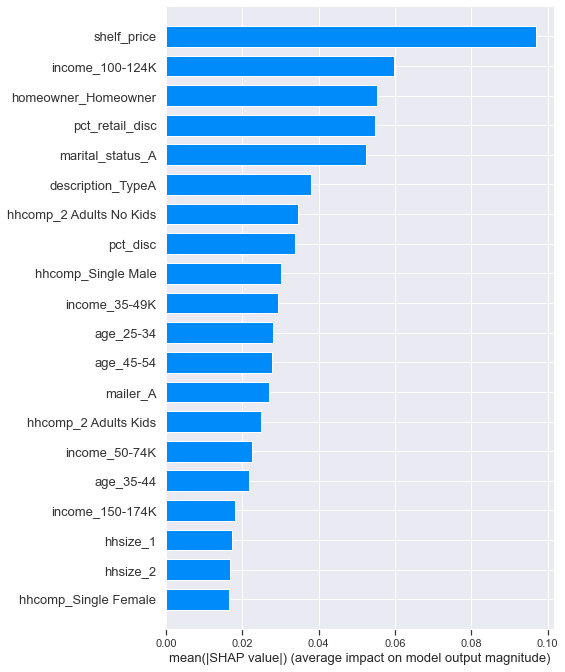

In [35]:
shap.summary_plot(shap_values, X_test[:1000], plot_type="bar")

In [13]:
shap_values = shap_values.to_numpy()

In [14]:
shap_values

array([[-0.0140458 ,  0.00368947,  0.091774  , ...,  0.        ,
        -0.07681243, -0.00624664],
       [-0.03123047, -0.01798553, -0.03989852, ..., -0.00729104,
         0.05041219, -0.0332614 ],
       [-0.06022784, -0.02741274,  0.17436748, ...,  0.00867867,
         0.02216909, -0.01768178],
       ...,
       [-0.04390148,  0.0123904 ,  0.04991837, ...,  0.        ,
         0.02111158,  0.        ],
       [-0.15373254,  0.01776804, -0.06374297, ...,  0.        ,
         0.02409338,  0.00600863],
       [-0.01894527,  0.01815609, -0.00959158, ...,  0.00181142,
         0.01494558,  0.        ]])

## In addition, the beeswarm plot shows the direction of the impact:

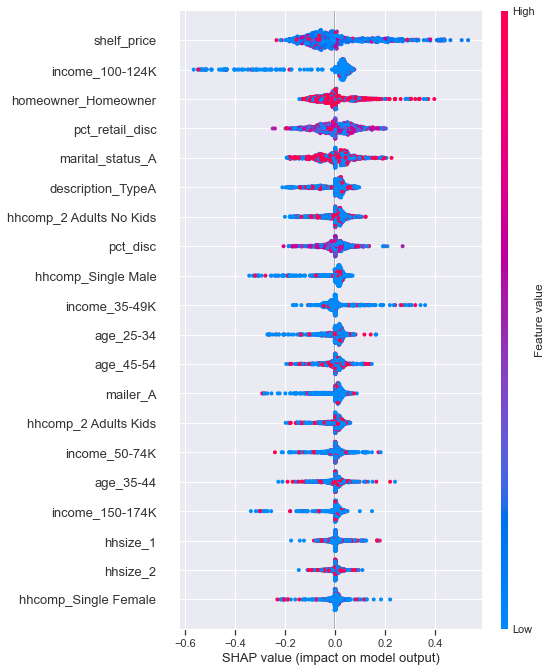

In [15]:
shap.summary_plot(shap_values, features=X_test[:1000], feature_names=X_test.columns)